In [1]:
from typing import Dict, Iterable, Optional
import scanpy as sc
import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
import scvi
from scvi import REGISTRY_KEYS
from scvi._compat import Literal
from scvi.distributions import NegativeBinomial, ZeroInflatedNegativeBinomial
from scvi.module._peakvae import Decoder as DecoderPeakVI
from scvi.module.base import BaseModuleClass, LossRecorder, auto_move_data
from scvi.nn import DecoderSCVI, Encoder, FCLayers
from scvi.module import MULTIVAE

from anndata import AnnData
from typing import Dict, Iterable, List, Optional, Sequence, Union
from scvi.model import MULTIVI 

Global seed set to 0


In [2]:
adata_multi = sc.read_h5ad("halo/E18_mouse_Brain/multiomic.h5ad")
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))


In [3]:
n_genes=(adata_mvi.var['modality']=='Gene Expression').sum()
newX = adata_mvi.X[:, :n_genes]
scdata = AnnData(X = newX)
scdata.obs = adata_mvi.obs
scdata.var = adata_mvi.var[:n_genes]

In [4]:
scvi.model.SCVI.setup_anndata(
    scdata)

In [5]:
model = scvi.model.SCVI(scdata)

In [7]:
model.module.log_variational

True

In [21]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [02:42<00:00,  2.46it/s, loss=9.33e+03, v_num=1]


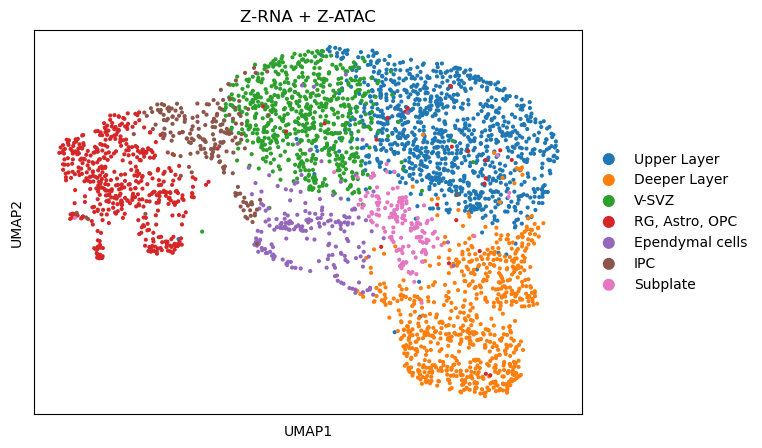

In [22]:
import matplotlib.pyplot as plt
latent = model.get_latent_representation()


adata_mvi.obsm["latent"] = latent
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.scatter(adata_mvi,color='celltype',basis='umap',
             title = 'Z-RNA + Z-ATAC')
plt.show()

In [4]:

adata_multi = scvi.data.organize_multiome_anndatas(scdata)
scvi.model.MULTIVI.setup_anndata(adata_multi, batch_key="modality")

mvi_p = MULTIVI(
    adata_multi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=0,
)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [5]:
mvi_p.train(use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/torch/nn/modules/linear.py:114: UserWarning: An output with one or more elements was resized since it had shape [128, 120], which does not match the required output shape [120]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/aten/src/ATen/native/Resize.cpp:24.)
  return F.linear(input, self.weight, self.bias)
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/module/_multivae.py:557: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. 

RuntimeError: The size of tensor a (128) must match the size of tensor b (10) at non-singleton dimension 1